In [1]:
%config InlineBackend.figure_format='retina'

# Add the parent directory to the path so that we can import the modules.
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from market_conditions import *
from dynamic_contagion import *
from reinsurance import *

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Other parameters
maturity = 3
markup = 0.4
R = int(1e5)
seed = 123

# Asset parameters
V_0 = 130
phi_V = -3  # * (1.3) # = V0 / L0
sigma_V = 0.05

# Liability parameters
L_0 = 100
phi_L = -3
sigma_L = 0.02

# Interest rate parameters
r_0 = 0.02
k = 0.2
m = 0.05  # 0.5
upsilon = 0.1
eta_r = -0.01

# Catastrophe loss size distribution parameters
mu_C = 2
sigma_C = 0.5

In [3]:
# Poisson process
def simulate_poisson(seed):
    lambda_ = 0.5
    rg = rnd.default_rng(seed)
    return rg.poisson(lambda_ * maturity)


# Cox proces
def simulate_cox(seed):
    lambda0 = 0.49
    a = 0.4
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 0.0, 0.0, 0.5
    )


# Hawkes process
def simulate_hawkes(seed):
    lambda0 = 0.47
    a = 0.26
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 1.0, 0.0, 0.0
    )


# Dynamic contagion process
def simulate_dcp(seed):
    lambda0 = 0.29
    a = 0.26
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 1.0, 0.0, 0.5
    )

In [4]:
%%time

catbond_fn = lambda C_T, K, F_cat: np.minimum(np.maximum(C_T - K, 0), F_cat)

safe_prices = reinsurance_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup,
    As = 10.0,
    Ms = 70.0,
	catbond=True,
    K = 40.0,
    psi_T = catbond_fn,
    F_cat = 100.0
)

risky_prices = reinsurance_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup,
)


catbond_premium = safe_prices - risky_prices

CPU times: user 3.34 s, sys: 162 ms, total: 3.5 s
Wall time: 3.5 s


In [5]:
safe_prices

7.321323283066884

In [6]:
risky_prices

2.801521070833136

In [7]:
catbond_premium

4.519802212233748

In [8]:
delta_0 = catbond_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup = 0.0,
    As = 10.0,
    Ms = 70.0,
    K = 40.0,
    psi_T = catbond_fn,
    F_cat = 100.0
)


In [9]:
delta_0

91.86681212219811

In [10]:
%%time

face_values = np.linspace(0.0, 2, 5)
present_values = np.empty_like(face_values)

for i, face_value in enumerate(face_values):
	present_values[i] = reinsurance_prices(
		R,
		seed,
		maturity,
		k,
		eta_r,
		m,
		phi_V,
		sigma_V,
		phi_L,
		sigma_L,
		upsilon,
		V_0,
		L_0,
		r_0,
		simulate_poisson,
		mu_C,
		sigma_C,
		markup = 0.0,
		As = 10.0,
		Ms = 70.0,
		catbond=True,
		K = 10.0,
		psi_T = catbond_fn,
		F_cat = face_value
	)

CPU times: user 8.14 s, sys: 340 ms, total: 8.48 s
Wall time: 8.48 s


In [11]:
present_values

array([5.18608276, 5.19037674, 5.19450239, 5.19847806, 5.20230987])

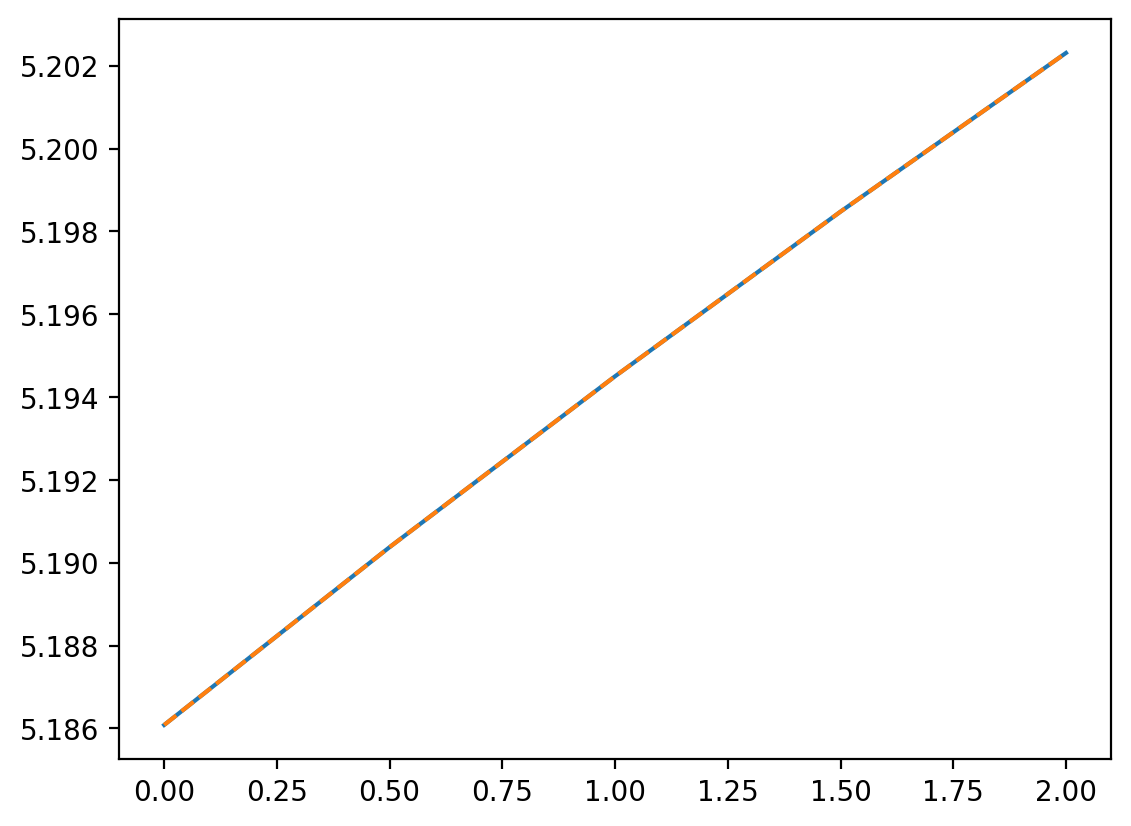

In [12]:
plt.plot(face_values, present_values);
plt.plot(face_values, present_values, ls="--");
# plt.plot(face_values, face_values / face_values[-1] * present_values[-1], ls="--")

In [13]:
free_bond = catbond_prices(
        R,
        seed,
        maturity,
        k,
        eta_r,
        m,
        phi_V,
        sigma_V,
        phi_L,
        sigma_L,
        upsilon,
        V_0,
        L_0,
        r_0,
        simulate_poisson,
        mu_C,
        sigma_C,
        markup = 0.0,
        As = 10.0,
        Ms = 70.0,
        K = 70.0,
        psi_T = catbond_fn,
        F_cat = 0.0
    )
	
free_bond

0.0

In [14]:
%%time
face_values = np.linspace(0.0, 2, 5)
deltas = np.empty_like(face_values)

for i, face_value in enumerate(face_values):
    deltas[i] = catbond_prices(
        R,
        seed,
        maturity,
        k,
        eta_r,
        m,
        phi_V,
        sigma_V,
        phi_L,
        sigma_L,
        upsilon,
        V_0,
        L_0,
        r_0,
        simulate_poisson,
        mu_C,
        sigma_C,
        markup = 0.0,
        As = 10.0,
        Ms = 70.0,
        K = 10.0,
        psi_T = catbond_fn,
        F_cat = face_value
    )

CPU times: user 7.94 s, sys: 353 ms, total: 8.29 s
Wall time: 8.29 s


In [15]:
deltas

array([0.        , 0.23142451, 0.47090613, 0.71827594, 0.97308058])

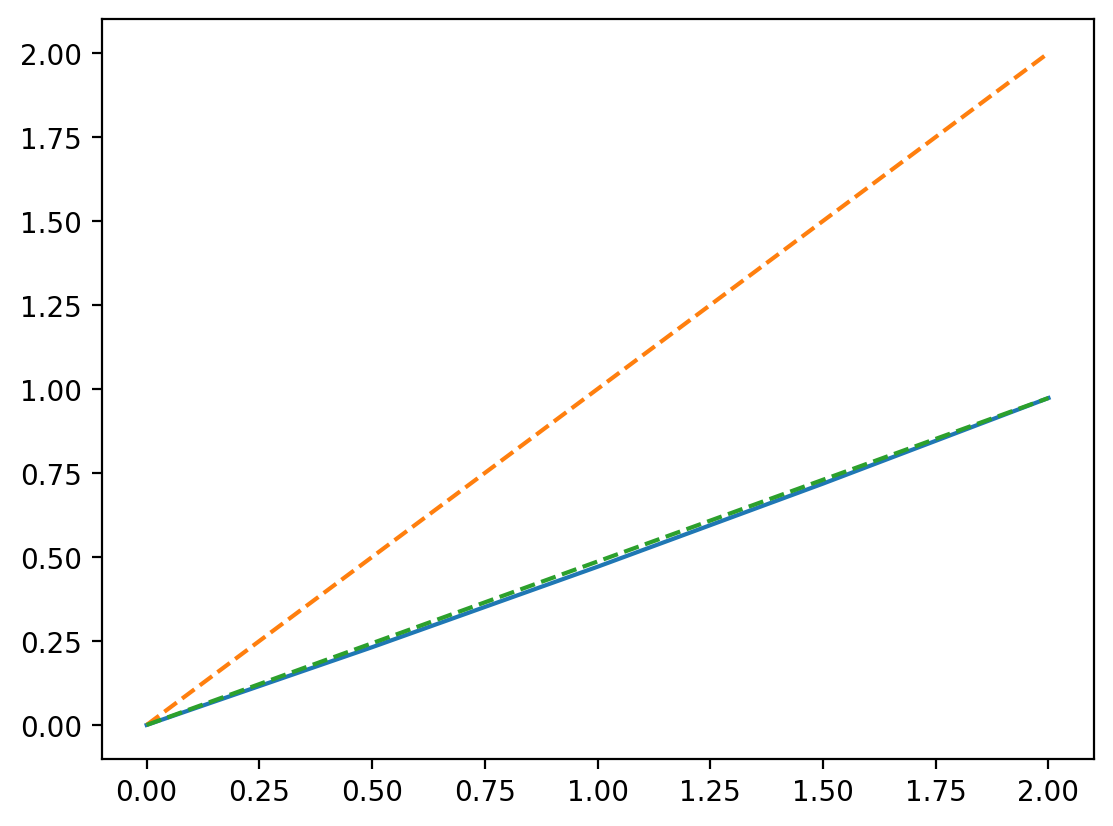

In [16]:
plt.plot(face_values, deltas);
plt.plot(face_values, face_values, ls="--")
plt.plot(face_values, face_values / face_values[-1] * deltas[-1], ls="--")

## Attempt the optimisation problem (Poisson)

In [17]:
catbond_markup = 0.05

def net_present_value(K, F_cat):
	reinsurance_pv = reinsurance_prices(
		R,
		seed,
		maturity,
		k,
		eta_r,
		m,
		phi_V,
		sigma_V,
		phi_L,
		sigma_L,
		upsilon,
		V_0,
		L_0,
		r_0,
		simulate_poisson,
		mu_C,
		sigma_C,
		markup = 0.0,
		As = 10.0,
		Ms = 70.0,
		catbond=True,
		K = K,
		psi_T = catbond_fn,
		F_cat = F_cat
	)

	delta_0 = catbond_prices(
		R,
		seed,
		maturity,
		k,
		eta_r,
		m,
		phi_V,
		sigma_V,
		phi_L,
		sigma_L,
		upsilon,
		V_0,
		L_0,
		r_0,
		simulate_poisson,
		mu_C,
		sigma_C,
		markup = 0.0,
		As = 10.0,
		Ms = 70.0,
		K = K,
		psi_T = catbond_fn,
		F_cat = F_cat
	)

	return markup * reinsurance_pv - catbond_markup * delta_0

In [18]:
net_present_value(10.0, 100.0)

-2.226489851183604

In [19]:
%%time
A = 10.0
K = A
for F_cat in [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0]:
		print(f'K = {K}, F_cat = {F_cat}, NPV = {net_present_value(K, F_cat)}')


K = 10.0, F_cat = 0.0, NPV = 2.0744331036659216
K = 10.0, F_cat = 0.1, NPV = 2.0724985711570327
K = 10.0, F_cat = 0.5, NPV = 2.0645794708372254
K = 10.0, F_cat = 1.0, NPV = 2.0542556511672307
K = 10.0, F_cat = 5.0, NPV = 1.9562736838144672
K = 10.0, F_cat = 10.0, NPV = 1.8010579501106805
K = 10.0, F_cat = 20.0, NPV = 1.4174625557848697
K = 10.0, F_cat = 30.0, NPV = 0.9841427100846039
K = 10.0, F_cat = 40.0, NPV = 0.5325475445184147
K = 10.0, F_cat = 50.0, NPV = 0.07473983297200126
K = 10.0, F_cat = 100.0, NPV = -2.226489851183604
K = 10.0, F_cat = 150.0, NPV = -4.52878831185334
CPU times: user 38.8 s, sys: 1.67 s, total: 40.5 s
Wall time: 40.5 s


## Attempt the optimisation problem (DCP)

In [20]:
catbond_markup = 0.05

def net_present_value(K, F_cat):
	reinsurance_pv = reinsurance_prices(
		R,
		seed,
		maturity,
		k,
		eta_r,
		m,
		phi_V,
		sigma_V,
		phi_L,
		sigma_L,
		upsilon,
		V_0,
		L_0,
		r_0,
		simulate_dcp,
		mu_C,
		sigma_C,
		markup = 0.0,
		As = 10.0,
		Ms = 70.0,
		catbond=True,
		K = K,
		psi_T = catbond_fn,
		F_cat = F_cat
	)

	delta_0 = catbond_prices(
		R,
		seed,
		maturity,
		k,
		eta_r,
		m,
		phi_V,
		sigma_V,
		phi_L,
		sigma_L,
		upsilon,
		V_0,
		L_0,
		r_0,
		simulate_dcp,
		mu_C,
		sigma_C,
		markup = 0.0,
		As = 10.0,
		Ms = 70.0,
		K = K,
		psi_T = catbond_fn,
		F_cat = F_cat
	)

	return markup * reinsurance_pv - catbond_markup * delta_0

In [21]:
net_present_value(10.0, 100.0)

-1.7729822345887043

In [22]:
%%time
A = 10.0
K = A
for F_cat in [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0]:
		print(f'K = {K}, F_cat = {F_cat}, NPV = {net_present_value(K, F_cat)}')


K = 10.0, F_cat = 0.0, NPV = 2.3863792979588783
K = 10.0, F_cat = 0.01, NPV = 2.3861847694187888
K = 10.0, F_cat = 0.05, NPV = 2.385405058941156
K = 10.0, F_cat = 0.1, NPV = 2.3844271795985916
K = 10.0, F_cat = 0.5, NPV = 2.3764741718191376
K = 10.0, F_cat = 1.0, NPV = 2.366209645217634
K = 10.0, F_cat = 5.0, NPV = 2.2721899855823255
K = 10.0, F_cat = 10.0, NPV = 2.1296572124059905
K = 10.0, F_cat = 20.0, NPV = 1.7840908836494727
CPU times: user 16.2 s, sys: 1.14 s, total: 17.3 s
Wall time: 17.3 s


In [23]:
%%time
no_bond_npv = net_present_value(K, 0.0)

face_values = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0]
strikes = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0]

npvs = np.empty((len(face_values), len(strikes)), dtype = float)

for i, face_value in enumerate(face_values):
	for j, strike in enumerate(strikes):
		npvs[i,j] = net_present_value(strike, face_value)
		if npvs[i,j] > no_bond_npv:
			print(f'K = {K}, F_cat = {F_cat}, NPV = {npvs[i,j]}')
	

In [24]:
npvs.round(4)

array([[2.3864, 2.3864, 2.3864, 2.3864, 2.3864, 2.3864, 2.3864],
       [2.3862, 2.3861, 2.386 , 2.386 , 2.386 , 2.386 , 2.3859],
       [2.3854, 2.385 , 2.3847, 2.3845, 2.3844, 2.3843, 2.3842],
       [2.3844, 2.3835, 2.383 , 2.3827, 2.3824, 2.3821, 2.382 ],
       [2.3765, 2.3721, 2.3696, 2.3678, 2.3663, 2.3652, 2.3644],
       [2.3662, 2.3576, 2.3527, 2.3491, 2.3462, 2.344 , 2.3424],
       [2.2722, 2.2342, 2.212 , 2.1957, 2.1824, 2.1724, 2.1656],
       [2.1297, 2.0636, 2.0248, 1.9959, 1.9721, 1.9543, 1.9421],
       [1.7841, 1.6822, 1.6211, 1.5752, 1.5372, 1.5087, 1.4901]])